In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import h5py
import obspy
from obspy.signal.filter import envelope
from obspy.clients.fdsn import Client
from glob import glob #is a function that’s used to search for files that match a specific file pattern or name.
import random

from scipy import signal

In [3]:
def extract_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
        st.append(f['/data/'+bucket][ind, :3, :18000])
        
    return st

def extract_Z_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
#         st.append(f['/data/'+bucket][ind, 2, :18000])
        waveforms = f['/data/'+bucket][ind, 2, :18000]
        wave = waveforms[np.newaxis, np.newaxis, :]
        st.append(wave)
        
    return st


def convert_into_traces(stream, cat):
    channels = ['BHE','BHN','BHZ'] 
    
    st = []  
    for i in range(len(stream)):
        for j in range(len(stream[i])):
            tr = obspy.Trace(stream[i][j])
            tr.stats.channel = channels[j]
            tr.stats.station = cat['station_code'].values[i]
            tr.stats.network = cat['station_network_code'].values[i]
            tr.stats.sampling_rate = 100
            tr.stats.starttime = obspy.UTCDateTime(cat['trace_start_time'].values[i])
            
            st.append(tr)
            
    return obspy.Stream(st)

def convert_time_windows_and_plot(trace, init_time=0, final_time=150, threshhold_low=0.02, threshold_high=0.98, time_before_p=10, time_after_p=90):
    fig, axs = plt.subplots(2, len(trace), figsize = (5*len(trace), 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
    
    array = []
                            
    for i in range(len(trace)):
        
        sampling_rate = 100
        t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
        d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
        a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
        lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
        upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
        dur = t[upper_index] - t[lower_index]
        lower_time_index =  lower_index - time_before_p * sampling_rate
        upper_time_index =  lower_index + time_after_p * sampling_rate
        
        new_d = d[lower_time_index:upper_time_index]
        new_t = t[lower_time_index:upper_time_index]
        new_a = a[lower_time_index:upper_time_index]


        array.append(new_d)
                            
         ## plotting the seismogram
        axs[0,i].plot(new_t, new_d)
        axs[0,i].set_ylabel('Amplitude')
#         axs[0,i].set_xlim(lower_time_index/sampling_rate, upper_time_index/sampling_rate)
        axs[0,i].axvline(t[lower_index], ls = '--', color='black')
        axs[0,i].axvline(t[upper_index], ls = '--', color='black')
        axs[0,i].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
        axs[1,i].plot(new_t, new_a)
        axs[1,i].set_xlabel('Time')
        axs[1,i].set_ylabel('Energy')
#         axs[1,i].set_xlim(lower_time_index/sampling_rate, upper_time_index/sampling_rate)
        axs[1,i].axvline(t[lower_index], ls = '--', color='black')
        axs[1,i].axvline(t[upper_index], ls = '--', color='black')
    
        
    fig.suptitle(str(trace[0].stats.starttime)+' '+trace[0].id, fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()
                            
    return array

def plot_duration_mag(trace, dur_mag, threshold_low=0.02, threshold_high=0.98, title = 'Thunder Waveforms', init_time = 0, final_time = 150):
    
    duration = []
    
    for j in range(len(trace)):
        
            #fig, axs = plt.subplots(2, 1, figsize = (12, 12))
        
            sampling_rate = 100
            d = trace[j].data[init_time*sampling_rate:final_time*sampling_rate]
            t = trace[j].times()[init_time*sampling_rate:final_time*sampling_rate]
            a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
            lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
            upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
            dur = t[upper_index] - t[lower_index]
            
            duration.append(dur)
    
    plt.figure(figsize=(15,10))
    plt.plot(dur_mag, duration, 'o')
    plt.yscale('log')
    plt.xlabel('Duration Magnitude', fontsize=15)
    plt.ylabel('Duration [s]', fontsize=15)
    plt.title(title, fontsize=20)
            
    # Show the plot
    plt.show()
    return duration

### Modfiy the Duration Measurements so that the Duration Starts at the Peak Amplitude and ends at 99% of the Cumulative Energy

In [4]:
# collecting waveform data and corresponding catalog.
comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = "/data/whd01/yiyu_data/PNWML/comcat_metadata.csv"

noise_file_name = "/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5"
noise_csv_file = "/data/whd01/yiyu_data/PNWML/noise_metadata.csv"

exotic_file_name = "/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5"
exotic_csv_file = "/data/whd01/yiyu_data/PNWML/exotic_metadata.csv"

In [5]:
## collecting the catalog and storing it. 
# pd.read_csv: Read a comma-separated values (csv) file into DataFrame (tables).
cat_high_snrs = pd.read_csv('highest_snrs_durations.csv')
cat_comcat = pd.read_csv(comcat_csv_file)
cat_noise = pd.read_csv(noise_csv_file)
cat_exotic = pd.read_csv(exotic_csv_file)

In [6]:
## making SNR in correct format
snrs_exotic = []
for i in range(len(cat_exotic['trace_snr_db'])):
    snrs_exotic.append(np.array(cat_exotic['trace_snr_db'].values[i].split('|')).astype('float')[-1])
    
snrs_comcat = []
for i in range(len(cat_comcat['trace_snr_db'])):
    snrs_comcat.append(np.array(cat_comcat['trace_snr_db'].values[i].split('|')).astype('float')[-1])

In [7]:
cat_exotic['snr_final'] = snrs_exotic
cat_comcat['snr_final'] = snrs_comcat

In [8]:
cat_thunder = cat_exotic[cat_exotic['source_type'] == 'thunder']
cat_surface = cat_exotic[cat_exotic['source_type'] == 'surface event']
cat_sonic = cat_exotic[cat_exotic['source_type'] == 'sonic boom']
cat_plane = cat_exotic[cat_exotic['source_type'] == 'plane crash']

cat_explosion = cat_comcat[cat_comcat['source_type'] == 'explosion']
cat_earthquake = cat_comcat[cat_comcat['source_type'] == 'earthquake']

In [9]:
cat_thunder_good = cat_thunder.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]
cat_surface_good = cat_surface.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]
cat_sonic_good = cat_sonic.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]
cat_plane_good = cat_plane.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]
cat_explosion_good = cat_explosion.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]
cat_earthquake_good = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]

In [10]:
#Convert into traces
stream_exotic = extract_waveforms(cat_thunder_good, exotic_file_name)
tr_thunder_Z = convert_into_traces(stream_exotic, cat_thunder_good).select(channel = '*HZ')

stream_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
tr_earthquake_Z = convert_into_traces(stream_earthquake, cat_earthquake_good).select(channel = '*HZ')

stream_surface = extract_waveforms(cat_surface_good, exotic_file_name)
tr_surface_Z = convert_into_traces(stream_surface, cat_surface_good).select(channel = '*HZ')

stream_explosion = extract_waveforms(cat_explosion_good, comcat_file_name)
tr_explosion_Z = convert_into_traces(stream_explosion, cat_explosion_good).select(channel = '*HZ')

stream_sonic = extract_waveforms(cat_sonic_good, exotic_file_name)
tr_sonic_Z = convert_into_traces(stream_sonic, cat_sonic_good).select(channel = '*HZ')

stream_plane = extract_waveforms(cat_plane_good, exotic_file_name)
tr_plane_Z = convert_into_traces(stream_plane, cat_plane_good).select(channel = '*HZ') 

In [20]:
len(cat_thunder)

146

In [242]:
cat_high_snrs[0:3]

,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,...,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final,durations
0,119605,uw61362346,2018-01-03T08:36:25.940000Z,46.256,-122.056,earthquake,10.230,3.82,ml,0.149,...,eq,3.82,0.149,4.20,0.306,NaN,0,0,76.523,12.47
1,58318,uw60563331,2013-08-03T02:11:16.250000Z,46.327,-122.391,earthquake,13.199,3.12,ml,0.275,...,eq,3.12,0.275,3.12,0.336,NaN,0,0,73.933,8.47
2,127484,uw61504942,2018-11-19T11:09:13.050000Z,47.698,-123.552,earthquake,39.320,4.08,ml,0.163,...,eq,4.08,0.163,4.11,0.349,NaN,0,0,73.801,17.23


In [219]:
cat = cat_comcat['source_type'] == 'noise'

In [220]:
cat[0:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: source_type, dtype: bool

In [214]:
cat_noise[0:5]

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time
0,noise,UW,BH,TTW,--,47.694,-121.690,542.0,"bucket1$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
1,noise,UW,HH,ERW,--,48.454,-122.626,387.0,"bucket2$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
2,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket3$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
3,noise,UW,BH,OPC,--,48.100,-123.413,90.0,"bucket4$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
4,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket5$0,:3,:15001",100,2002-09-13T14:54:54.050000Z


In [215]:
cat_exotic[0:5]

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
0,pnsn3166678,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$0,:3,:18001",100,2021-08-02T03:17:19.000000Z,NaN,NaN,7000.0,emergent,23.922|19.759|28.482
1,pnsn3166673,thunder,UW,EH,NCO,--,43.704,-121.140,1908.0,"bucket3$1,:3,:18001",100,2021-08-02T03:06:44.000000Z,NaN,NaN,7000.0,emergent,nan|nan|18.054
2,pnsn3165628,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$2,:3,:18001",100,2021-07-26T12:37:35.000000Z,NaN,NaN,7000.0,impulsive,13.149|20.561|19.350
3,pnsn3165633,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$3,:3,:18001",100,2021-07-26T12:30:25.000000Z,NaN,NaN,7000.0,emergent,6.389|6.103|3.934
4,pnsn3162793,thunder,CC,BH,TMBU,--,43.602,-121.145,1743.0,"bucket3$4,:3,:18001",100,2021-06-24T15:01:08.000000Z,NaN,NaN,7000.0,emergent,2.768|0.671|1.021


In [68]:
cat_noise_shuffle = cat_noise.sample(frac=1)

In [69]:
cat_noise_shuffle[0:5]

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time
35536,noise,CN,HH,GOBB,--,48.949,-123.510,173.0,"bucket2$3533,:3,:15001",100,2018-11-08T06:58:43.510000Z
12706,noise,PB,EH,B036,--,42.506,-123.382,315.3,"bucket10$1242,:3,:15001",100,2011-01-03T07:03:43.150000Z
15655,noise,PB,EH,B202,--,46.245,-122.137,1218.6,"bucket10$1534,:3,:15001",100,2012-01-09T19:54:43.850000Z
7767,noise,UW,EH,TDL,--,46.351,-122.217,1400.0,"bucket8$755,:3,:15001",100,2009-08-16T06:55:54.800000Z
21732,noise,UW,EH,WPW,--,46.699,-121.537,1280.0,"bucket2$2158,:3,:15001",100,2014-06-24T14:49:43.420000Z


In [70]:
cat_noise_good = cat_noise_shuffle.iloc[0:2000]

In [71]:
len(cat_noise_good)

2000

In [72]:
stream_noise = extract_waveforms(cat_noise_good, noise_file_name)
tr_noise = convert_into_traces(stream_noise, cat_noise_good).select(channel = '*HZ')
print(tr_noise[0:10])

10 Trace(s) in Stream:
CN.GOBB..BHZ | 2018-11-08T06:58:43.510000Z - 2018-11-08T07:01:13.510000Z | 100.0 Hz, 15001 samples
PB.B036..BHZ | 2011-01-03T07:03:43.150000Z - 2011-01-03T07:06:13.150000Z | 100.0 Hz, 15001 samples
PB.B202..BHZ | 2012-01-09T19:54:43.850000Z - 2012-01-09T19:57:13.850000Z | 100.0 Hz, 15001 samples
UW.TDL..BHZ  | 2009-08-16T06:55:54.800000Z - 2009-08-16T06:58:24.800000Z | 100.0 Hz, 15001 samples
UW.WPW..BHZ  | 2014-06-24T14:49:43.420000Z - 2014-06-24T14:52:13.420000Z | 100.0 Hz, 15001 samples
UW.HOOD..BHZ | 2021-01-21T06:10:38.810000Z - 2021-01-21T06:13:08.810000Z | 100.0 Hz, 15001 samples
UW.IRON..BHZ | 2020-02-13T05:54:30.760000Z - 2020-02-13T05:57:00.760000Z | 100.0 Hz, 15001 samples
CC.PR04..BHZ | 2018-02-03T13:26:55.360000Z - 2018-02-03T13:29:25.360000Z | 100.0 Hz, 15001 samples
PB.B201..BHZ | 2020-05-02T11:49:56.440000Z - 2020-05-02T11:52:26.440000Z | 100.0 Hz, 15001 samples
CC.CARB..BHZ | 2020-10-30T01:38:12.320000Z - 2020-10-30T01:40:42.320000Z | 100.0 Hz, 1

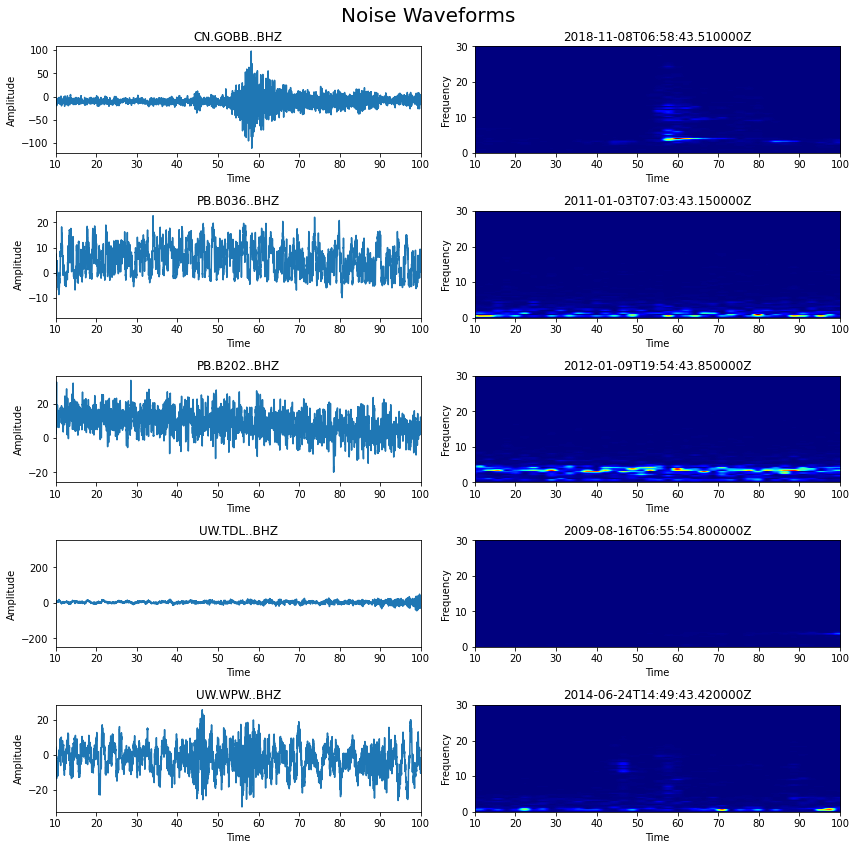

In [74]:
tr_exotic_Z = tr_noise[0:5]
xlim = [10,100]

# Create a figure with subplots
fig, axs = plt.subplots(len(tr_exotic_Z), 2, figsize=(12, 12))

for i in range(len(tr_exotic_Z)):
    time = tr_exotic_Z[i].times()
    # Plot time series in left subplot
    axs[i, 0].plot(time, tr_exotic_Z[i].data)
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].set_title(tr_exotic_Z[i].id)
    axs[i,0].set_xlim(xlim[0], xlim[1])

        # Compute and plot spectrogram in right subplot
    f, t_spec, Sxx = signal.spectrogram(tr_exotic_Z[i].data, fs = 100)
    axs[i, 1].imshow(Sxx, aspect='auto', cmap='jet', origin='lower', extent=[t_spec.min(), t_spec.max(), f.min(), f.max()])
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('Frequency')
    axs[i, 1].set_title(str(tr_exotic_Z[i].stats.starttime))
    axs[i, 1].set_xlim(xlim[0], xlim[1])
    axs[i, 1].set_ylim(0, 30)
    #axs[i, 1].set_yscale('log')

    # Labelling the figure. 
fig.suptitle("Noise Waveforms", fontsize = 20)


    # Adjust the spacing between subplots
plt.tight_layout()

    # Show the plot
plt.show()

### Create a numpy array that contains 2000 noise waveforms

In [105]:
n1 = np.zeros((2000,1,15000))

In [106]:
print(n1.shape)

(2000, 1, 15000)


In [107]:
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=90

trace = tr_noise

for i in range(len(trace)):
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
    
    n1[i][0][:] = d
    
print(n1.shape)
#     lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
#     dur = t[upper_index] - t[lower_index]
#     lower_time_index =  lower_index - time_before_p * sampling_rate
#     upper_time_index =  lower_index + time_after_p * sampling_rate
        
#     new_d = d[lower_time_index:upper_time_index]
#     new_t = t[lower_time_index:upper_time_index]
#     new_a = a[lower_time_index:upper_time_index]


(2000, 1, 15000)


In [108]:
n1[0:15]

array([[[-7.24834962e+00, -2.87497791e+01, -5.57519232e+01, ...,
         -1.02511732e+01, -4.25012286e+00, -2.49507917e-01]],

       [[ 2.49886001e-01,  4.99605288e-01, -9.25442669e-04, ...,
         -1.74893857e+00, -2.99947196e+00, -1.49959231e+00]],

       [[ 7.49459455e-01,  3.24882783e+00,  6.49809064e+00, ...,
         -7.47215519e-01,  1.98071187e-03,  2.50926717e-01]],

       ...,

       [[-7.49697678e-01, -2.24985952e+00, -2.24967493e+00, ...,
         -4.00110060e+00, -6.25109970e+00, -5.25070117e+00]],

       [[ 4.27341178e+01,  2.06741192e+02,  3.97507984e+02, ...,
         -2.98203090e+00, -9.74120550e+00, -1.02487965e+01]],

       [[ 1.53972623e+02,  2.35108144e+02,  2.14732370e+02, ...,
         -5.23607308e+02, -5.01972257e+02, -3.81617428e+02]]])

### Downsample the noise data and make a h5 file

In [109]:
wave = n1
print(wave.shape)

(2000, 1, 15000)


In [110]:
# Downsample data
arr_earthquake_downsamp = signal.decimate(wave, 5)

In [111]:
print(arr_earthquake_downsamp.shape)

(2000, 1, 3000)


In [112]:
# Make a file
with h5py.File('shuffled_noise_Z_20Hz.h5', 'w') as f:
    f.create_dataset('quake', data=arr_earthquake_downsamp)

### Normalize the noise data and make a normalized data file

In [155]:
# Read the waveform data of noise downsampled to 20 Hz
with h5py.File('shuffled_noise_Z_20Hz.h5', 'r') as f:
    wave_noise = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave_noise.shape)

(2000, 1, 3000)


In [152]:
noise_normalized = (wave_noise - np.mean(wave_noise, axis=1, keepdims=True)) / (np.std(wave_noise, axis=1, keepdims=True) + 1e-12)

In [153]:
print(noise_normalized.shape)

(2000, 1, 3000)


(array([   0.,    0.,    0.,    0.,    0., 3000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

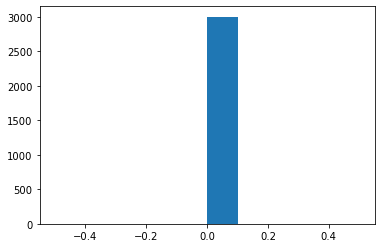

In [154]:
plt.hist(noise_normalized[1][0])

In [156]:
noise_normalized = np.zeros((2000,1,3000))

In [163]:
for i in range(len(wave_noise)):
    noise_normalized[i][0][:] = (wave_noise[i][0][:] - np.mean(wave_noise[i][0][:])) /(np.std(wave_noise[i][0][:])+1e-12)

(array([ 24., 206., 394., 441., 513., 505., 483., 353.,  79.,   2.]),
 array([-2.54641521, -2.01591783, -1.48542045, -0.95492308, -0.4244257 ,
         0.10607168,  0.63656905,  1.16706643,  1.69756381,  2.22806118,
         2.75855856]),
 <BarContainer object of 10 artists>)

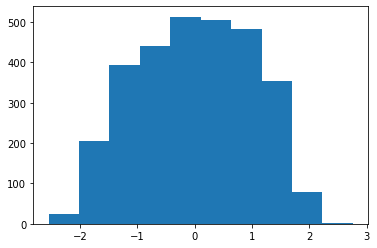

In [167]:
plt.hist(noise_normalized[77][0])

In [168]:
with h5py.File('noise_Z_20Hz_norm.h5', 'w') as f:
    f.create_dataset('quake', data=noise_normalized)

### Normalized the earthquake data

In [169]:
# Read the waveform data of noise downsampled to 20 Hz
with h5py.File('good_earthquake_Z1_20Hz.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 3000)


In [170]:
earthquake_normalized = np.zeros((2000,1,3000))

In [171]:
for i in range(len(wave)):
    earthquake_normalized[i][0][:] = (wave[i][0][:] - np.mean(wave[i][0][:])) /(np.std(wave[i][0][:])+1e-12)

(array([1.000e+00, 3.000e+00, 1.200e+01, 6.500e+01, 2.896e+03, 1.300e+01,
        9.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-16.34301246, -12.4477809 ,  -8.55254934,  -4.65731777,
         -0.76208621,   3.13314536,   7.02837692,  10.92360848,
         14.81884005,  18.71407161,  22.60930318]),
 <BarContainer object of 10 artists>)

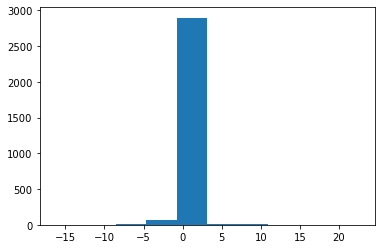

In [176]:
plt.hist(earthquake_normalized[1][0])

In [175]:
with h5py.File('earthquake_Z_20Hz_norm.h5', 'w') as f:
    f.create_dataset('quake', data=earthquake_normalized)

### Mix the earthquake and noise waveform data

In [177]:
# Read the waveform data of noise 
with h5py.File('noise_Z_20Hz_norm.h5', 'r') as f:
    noise = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(noise.shape)

(2000, 1, 3000)


In [178]:
# Read the waveform data of earthquakes 
with h5py.File('earthquake_Z_20Hz_norm.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 3000)


In [191]:
mixed_signal = np.zeros((2000,1,3000))

In [209]:
for i in range(len(wave)):
    x = np.random.rand()
    mixed_signal[i,0,:]= wave[i,0,:] * x + noise[i,0,:] * (1-x)

In [207]:
mixed_signal.shape

(2000, 1, 3000)

(array([1.000e+00, 4.000e+00, 1.900e+01, 2.945e+03, 2.600e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-16.98428152, -12.18977379,  -7.39526607,  -2.60075834,
          2.19374938,   6.98825711,  11.78276483,  16.57727255,
         21.37178028,  26.166288  ,  30.96079573]),
 <BarContainer object of 10 artists>)

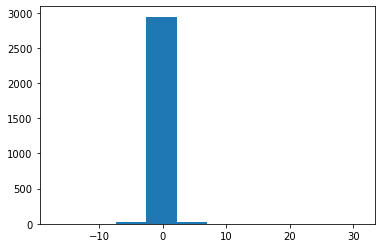

In [210]:
plt.hist(mixed_signal[8,0])

In [180]:
arr1 = np.array([1,2,3,4,5])
arr2 = np.array([5,4,3,2,1])

arr1+arr2

array([6, 6, 6, 6, 6])

In [188]:
10*np.random.rand()

2.620470531669471

### Make a file of the mixed data

In [202]:
with h5py.File('mixed_signal.h5', 'w') as f:
    f.create_dataset('quake', data=mixed_signal)

### Make a file for normalized test data

In [262]:
cat_earthquake_2001_to_3000 = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[2000:3000]

In [263]:
cat_earthquake_2001_to_3000

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,...,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final
61258,uw60622882,2013-11-04T10:25:03.190000Z,46.532,-122.294,earthquake,11.404,1.52,ml,0.111,1.37,...,nan|nan|43.628,eq,1.52,0.111,1.43,0.297,NaN,2,0,43.628
37440,uw10796318,2010-03-24T13:37:00.560000Z,46.342,-122.250,earthquake,7.717,1.70,ml,0.221,0.49,...,50.095|42.214|43.628,eq,1.70,0.221,1.70,0.030,NaN,0,0,43.628
108897,uw61334586,2017-09-28T08:05:33.680000Z,48.074,-121.632,earthquake,-0.770,2.19,ml,0.082,1.43,...,nan|nan|43.626,eq,2.19,0.082,2.26,0.331,NaN,2,0,43.626
138954,uw61510456,2019-02-01T09:05:19.550000Z,48.475,-122.939,earthquake,49.230,2.46,ml,0.154,0.90,...,45.963|51.307|43.623,eq,2.46,0.154,2.51,0.218,NaN,0,0,43.623
87633,uw61094127,2015-11-27T12:47:09.810000Z,46.878,-121.957,earthquake,4.890,1.69,ml,0.151,0.57,...,45.749|47.687|43.621,eq,1.69,0.168,1.94,0.450,NaN,0,0,43.621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48795,uw60434112,2012-08-01T20:53:36.650000Z,49.067,-122.231,earthquake,7.196,1.44,md,0.162,0.62,...,nan|nan|41.272,eq,NaN,NaN,1.44,0.162,NaN,2,0,41.272
138425,uw61563287,2019-12-09T01:00:25.490000Z,45.360,-121.696,earthquake,1.900,2.43,ml,0.148,0.42,...,39.877|46.164|41.27,eq,2.43,0.148,2.67,0.332,NaN,0,0,41.270
24752,uw10790503,2009-10-17T20:47:38.300000Z,46.376,-122.304,earthquake,15.972,1.83,ml,0.163,0.30,...,46.847|45.885|41.27,eq,1.83,0.163,1.70,0.030,NaN,0,0,41.270
75528,uw60883242,2014-10-02T22:30:48.980000Z,46.201,-122.180,earthquake,1.060,1.00,ml,0.299,0.19,...,41.98|38.517|41.267,eq,1.00,0.299,0.28,0.160,NaN,0,0,41.267


### Create a numpy array that contains 2000 thunder waveforms

In [51]:
trace=tr_thunder_Z
print(len(trace))

146


In [23]:
# Make zeros to contain the thunder waveforms
n1 = np.zeros((len(tr_thunder_Z),1,6000))

In [52]:
# Find the pre-P time for all the waveforms
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=50

duration = []
# pre-P time here is the time between the absolute start time and the P onset time in each trace
pre_p_time = []
array = np.zeros((2000, 1, 6000))

for i in range(len(trace)):
#     fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
    
    pre_p = lower_index - init_time
    
    pre_p_time.append(pre_p/100)
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]

(array([128.,  11.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   2.]),
 array([ 0.94 ,  8.033, 15.126, 22.219, 29.312, 36.405, 43.498, 50.591,
        57.684, 64.777, 71.87 ]),
 <BarContainer object of 10 artists>)

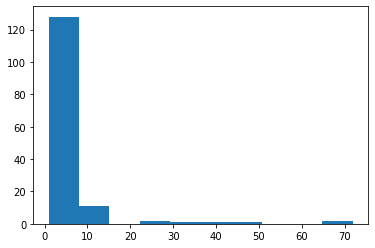

In [53]:
plt.hist(pre_p_time)

In [37]:
print(min(pre_p_time))

0.94


In [41]:
pre_p_time.index(0.94)

137

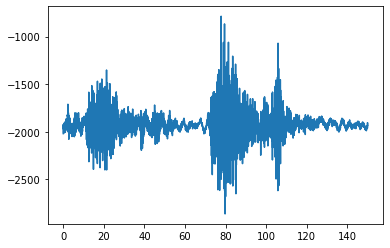

In [44]:
# Find the pre-P time for all the waveforms
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=50

duration = []
# pre-P time here is the time between the absolute start time and the P onset time in each trace
pre_p_time = []
array = np.zeros((2000, 1, 6000))
        
sampling_rate = 100
t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
plt.plot(t,d)

In [56]:
# Contain the thunder waveforms in the zeros. The time before P is 0s.
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=0
time_after_p=60

duration = []
arr_thunder = np.zeros((len(tr_thunder_Z), 1, 6000))

for i in range(len(trace)):
#     fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
    lower_time_index =  lower_index - time_before_p * sampling_rate
    upper_time_index =  lower_index + time_after_p * sampling_rate
    
    new_d = d[lower_time_index:upper_time_index]
    new_t = t[lower_time_index:upper_time_index]
    new_a = a[lower_time_index:upper_time_index]
    
    trace_abs = abs(new_d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

#     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
    upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]
    
    dur = new_t[upper_index] - new_t[peak_amp_index]

    duration.append(dur[0])
    
    arr_thunder[i,0,:] = new_d
    
#     # plotting the seismogram
#     axs[0].plot(new_t, new_d)
#     axs[0].set_ylabel('Amplitude')
# #     axs[0].set_xlim(xlim[0], xlim[1])
#     axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
#     axs[0].axvline(new_t[upper_index], ls = '--', color='black')
#     axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
#             # plotting the energy curve
#     axs[1].plot(new_t, new_a)
#     axs[1].set_xlabel('Time')
#     axs[1].set_ylabel('Energy')        
# #     axs[1].set_xlim(xlim[0], xlim[1])
#     axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
#     axs[1].axvline(new_t[upper_index], ls = '--', color='black')
        
#     fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
#     fig.tight_layout()
        
#     # Show the plot
#     plt.show()

In [65]:
len(duration)
duration_thunder = duration

In [58]:
arr_thunder.shape

(146, 1, 6000)

### Downsample the thunder waveforms

In [59]:
# Downsample data
arr_earthquake_downsamp = signal.decimate(arr_thunder, 5)

In [60]:
print(arr_earthquake_downsamp.shape)

(146, 1, 1200)


In [61]:
# Make a file
with h5py.File('thunder_Z_20Hz_1min.h5', 'w') as f:
    f.create_dataset('quake', data=arr_earthquake_downsamp)

### Make a CSV file for thunder waveforms 

In [72]:
cat_thunder_good

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db,snr_final,durations_peak_amp
9,pnsn3138083,thunder,CC,BH,KWBU,--,43.752,-121.312,1783.0,"bucket3$9,:3,:18001",100,2020-08-06T04:36:48.000000Z,NaN,NaN,7000.0,emergent,20.705|22.407|43.313,43.313,49.26
82,pnsn2169988,thunder,CC,EH,KWBU,--,43.752,-121.312,1783.0,"bucket3$82,:3,:18001",100,2015-07-10T22:37:25.000000Z,NaN,NaN,7000.0,impulsive,37.146|36.494|37.051,37.051,27.12
57,pnsn3096073,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$57,:3,:18001",100,2019-05-30T18:31:39.000000Z,NaN,NaN,7000.0,emergent,35.483|37.782|37.009,37.009,51.11
89,pnsn2150153,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$89,:3,:18001",100,2015-06-04T17:37:38.000000Z,7500.0,emergent,7000.0,impulsive,31.590|35.392|34.393,34.393,58.03
28,pnsn3104343,thunder,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket3$28,:3,:18001",100,2019-08-10T06:39:02.000000Z,NaN,NaN,7000.0,impulsive,21.601|23.785|31.992,31.992,8.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,pnsn2909043,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$69,:3,:18001",100,2018-05-24T23:15:39.000000Z,NaN,NaN,7000.0,emergent,-9.343|-0.270|-6.027,-6.027,37.23
74,pnsn2909248,thunder,CC,BH,NORM,--,43.739,-121.253,1286.0,"bucket3$74,:3,:18001",100,2018-05-24T22:34:12.000000Z,NaN,NaN,7000.0,emergent,-4.937|-8.186|-6.176,-6.176,47.26
73,pnsn2909253,thunder,CC,BH,NORM,--,43.739,-121.253,1286.0,"bucket3$73,:3,:18001",100,2018-05-24T22:37:18.000000Z,NaN,NaN,7000.0,emergent,-7.168|-4.517|-6.275,-6.275,37.61
43,pnsn3099013,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$43,:3,:18001",100,2019-07-01T01:30:51.000000Z,NaN,NaN,7000.0,emergent,-9.824|-6.733|-6.330,-6.330,42.63


In [71]:
cat_thunder_good['durations_peak_amp'] = duration_thunder

In [73]:
cat_thunder_good.to_csv('thunder_highest_snrs.csv')

In [74]:
cat_test = pd.read_csv('thunder_highest_snrs.csv')

In [75]:
cat_test

,Unnamed: 0,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db,snr_final,durations_peak_amp
0,9,pnsn3138083,thunder,CC,BH,KWBU,--,43.752,-121.312,1783.0,"bucket3$9,:3,:18001",100,2020-08-06T04:36:48.000000Z,NaN,NaN,7000.0,emergent,20.705|22.407|43.313,43.313,49.26
1,82,pnsn2169988,thunder,CC,EH,KWBU,--,43.752,-121.312,1783.0,"bucket3$82,:3,:18001",100,2015-07-10T22:37:25.000000Z,NaN,NaN,7000.0,impulsive,37.146|36.494|37.051,37.051,27.12
2,57,pnsn3096073,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$57,:3,:18001",100,2019-05-30T18:31:39.000000Z,NaN,NaN,7000.0,emergent,35.483|37.782|37.009,37.009,51.11
3,89,pnsn2150153,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$89,:3,:18001",100,2015-06-04T17:37:38.000000Z,7500.0,emergent,7000.0,impulsive,31.590|35.392|34.393,34.393,58.03
4,28,pnsn3104343,thunder,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket3$28,:3,:18001",100,2019-08-10T06:39:02.000000Z,NaN,NaN,7000.0,impulsive,21.601|23.785|31.992,31.992,8.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,69,pnsn2909043,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$69,:3,:18001",100,2018-05-24T23:15:39.000000Z,NaN,NaN,7000.0,emergent,-9.343|-0.270|-6.027,-6.027,37.23
142,74,pnsn2909248,thunder,CC,BH,NORM,--,43.739,-121.253,1286.0,"bucket3$74,:3,:18001",100,2018-05-24T22:34:12.000000Z,NaN,NaN,7000.0,emergent,-4.937|-8.186|-6.176,-6.176,47.26
143,73,pnsn2909253,thunder,CC,BH,NORM,--,43.739,-121.253,1286.0,"bucket3$73,:3,:18001",100,2018-05-24T22:37:18.000000Z,NaN,NaN,7000.0,emergent,-7.168|-4.517|-6.275,-6.275,37.61
144,43,pnsn3099013,thunder,CC,BH,CPCO,--,43.722,-121.233,2135.0,"bucket3$43,:3,:18001",100,2019-07-01T01:30:51.000000Z,NaN,NaN,7000.0,emergent,-9.824|-6.733|-6.330,-6.330,42.63


### Create a numpy array that contains 2000 surface waveforms


In [11]:
trace=tr_surface_Z
print(len(trace))

2000


In [12]:
# Make zeros to contain the thunder waveforms
n1 = np.zeros((len(tr_thunder_Z),1,6000))

In [13]:
# Find the pre-P time for all the waveforms
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=50

duration = []
# pre-P time here is the time between the absolute start time and the P onset time in each trace
pre_p_time = []
array = np.zeros((2000, 1, 6000))

for i in range(len(trace)):
#     fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
    
    pre_p = lower_index - init_time
    
    pre_p_time.append(pre_p/100)
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]

(array([792., 259., 136.,  78.,  51.,  58.,  74.,  55., 432.,  65.]),
 array([ 0.55 ,  8.717, 16.884, 25.051, 33.218, 41.385, 49.552, 57.719,
        65.886, 74.053, 82.22 ]),
 <BarContainer object of 10 artists>)

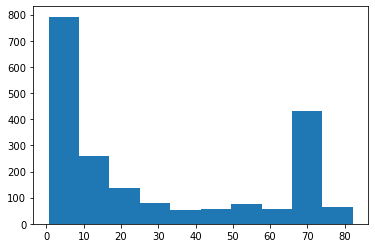

In [14]:
plt.hist(pre_p_time)

In [15]:
min(pre_p_time)

0.55

In [264]:
# Convert into traces
array_earthquake = extract_waveforms(cat_earthquake_2001_to_3000, comcat_file_name)
array_earthquake = convert_into_traces(array_earthquake, cat_earthquake_2001_to_3000).select(channel = '*HZ')
t = array_earthquake[0].times()[init_time*sampling_rate:final_time*sampling_rate]
d = array_earthquake[0].data[init_time*sampling_rate:final_time*sampling_rate]
print(t[0:10])
print(d[0:10])
print(len(array_earthquake))


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]
[ -1.24972567  -4.99952282  -6.99908181  -5.24762187  -6.24692804
 -10.24692374 -10.49623922  -5.99498774  -1.24375116  -0.24302249]
1000


In [322]:
trace = array_earthquake

In [323]:
len(trace)

1000

In [281]:
trace[508].data

array([ 2.00005774,  3.75068459,  2.25021148, ...,  3.24975651,
        0.49960577, -0.25032387])

In [346]:
# Create zeros to contain the adjusted waveform data 
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98

# I changed the time window for the 506th and 524th traces
time_before_p=5 
time_after_p=55

duration = []
array = np.zeros((1000, 1, 6000))
test = []
negative_index = []

for i in range(len(trace)):
#     fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
    lower_time_index =  lower_index - time_before_p * sampling_rate
    upper_time_index =  lower_index + time_after_p * sampling_rate
    
    if lower_time_index < 0 or upper_time_index < 0:
        print(str(i))
        pass
    else:
        new_d = d[lower_time_index:upper_time_index]
        new_t = t[lower_time_index:upper_time_index]
        new_a = a[lower_time_index:upper_time_index]

        test.append(new_d)

        trace_abs = abs(new_d)

        peak_amp = max(trace_abs)
        peak_amp_index = np.where(trace_abs == peak_amp)

    #     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
        upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]

        dur = new_t[upper_index] - new_t[peak_amp_index]

        duration.append(dur[0])

        array[i,0,:] = new_d
        
        
        
    # plotting the seismogram
#     axs[0].plot(new_t, new_d)
#     axs[0].set_ylabel('Amplitude')
# #     axs[0].set_xlim(xlim[0], xlim[1])
#     axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
#     axs[0].axvline(new_t[upper_index], ls = '--', color='black')
#     axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
#             # plotting the energy curve
#     axs[1].plot(new_t, new_a)
#     axs[1].set_xlabel('Time')
#     axs[1].set_ylabel('Energy')        
# #     axs[1].set_xlim(xlim[0], xlim[1])
#     axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
#     axs[1].axvline(new_t[upper_index], ls = '--', color='black')
        
#     fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
#     fig.tight_layout()
        
#     # Show the plot
#     plt.show()

In [306]:
print(len(test))

998


In [311]:
# Print the lower_index of the 506th trace
trace_test = trace[506]
sampling_rate = 100
t = trace_test.times()[init_time*sampling_rate:final_time*sampling_rate]
d = trace_test.data[init_time*sampling_rate:final_time*sampling_rate]
a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   

#Find the P-wave onset
lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]

lower_time_index =  lower_index - time_before_p * sampling_rate
upper_time_index =  lower_index + time_after_p * sampling_rate
print(lower_index)
print(lower_time_index)
print(upper_time_index)

# The output means there are only 7.1 seconds before the P onset  which means 10s don't works the pre-p lower time window. 

710
-290
5710


In [313]:
# Print the lower_index of the 524th trace
trace_test = trace[524]
sampling_rate = 100
t = trace_test.times()[init_time*sampling_rate:final_time*sampling_rate]
d = trace_test.data[init_time*sampling_rate:final_time*sampling_rate]
a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   

#Find the P-wave onset
lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]

lower_time_index =  lower_index - time_before_p * sampling_rate
upper_time_index =  lower_index + time_after_p * sampling_rate
print(lower_index)
print(lower_time_index)
print(upper_time_index)

# The output means there are only 8.43 seconds before the P onset  which means 10s don't works the pre-p lower time window. 

843
-157
5843


In [325]:
# Add these new durations to highest_snrs_durations_peak_amp.csv
len(duration)
print(len(duration))
print(duration[0:5])

1000
[10.670000000000002, 8.56000000000001, 22.339999999999996, 23.18, 18.249999999999993]


In [326]:
# Convert the 2001th through 3000th data into a CSV file
cat_earthquake_2001_to_3000.to_csv('cat_earthquake_2001_to_3000.csv')

In [347]:
cat_earthquake_test = pd.read_csv('cat_earthquake_2001_to_3000.csv')

In [348]:
cat_earthquake_test['durations_peak_amp']=duration

In [354]:
len(cat_earthquake_test1)

1000

In [351]:
# Convert the 2001th through 3000th data into a CSV file
cat_earthquake_test.to_csv('cat_earthquake_2001_to_3000.csv')

In [352]:
cat_earthquake_test1 = pd.read_csv('cat_earthquake_2001_to_3000.csv')

In [353]:
cat_earthquake_test1[0:5]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,...,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final,durations_peak_amp
0,0,0,61258,uw60622882,2013-11-04T10:25:03.190000Z,46.532,-122.294,earthquake,11.404,1.52,...,eq,1.52,0.111,1.43,0.297,NaN,2,0,43.628,10.67
1,1,1,37440,uw10796318,2010-03-24T13:37:00.560000Z,46.342,-122.250,earthquake,7.717,1.70,...,eq,1.70,0.221,1.70,0.030,NaN,0,0,43.628,8.56
2,2,2,108897,uw61334586,2017-09-28T08:05:33.680000Z,48.074,-121.632,earthquake,-0.770,2.19,...,eq,2.19,0.082,2.26,0.331,NaN,2,0,43.626,22.34
3,3,3,138954,uw61510456,2019-02-01T09:05:19.550000Z,48.475,-122.939,earthquake,49.230,2.46,...,eq,2.46,0.154,2.51,0.218,NaN,0,0,43.623,23.18
4,4,4,87633,uw61094127,2015-11-27T12:47:09.810000Z,46.878,-121.957,earthquake,4.890,1.69,...,eq,1.69,0.168,1.94,0.450,NaN,0,0,43.621,18.25


### Making files of earthquake (2001th-3000th) with an adjusted time window


In [355]:
# Make an h5 file containing new waveform data
arr_earthquake_downsamp = signal.decimate(array, 5, axis=-1)
print(arr_earthquake_downsamp.shape)

(1000, 1, 1200)


In [356]:
arr_earthquake_downsamp[0]

array([[ 4.63587268, -0.12251209, -0.88487797, ..., 10.46663106,
        14.84140317, 14.94581357]])

In [357]:
# Make a file
with h5py.File('earthquake_2001_to_3000_Z_20Hz_1min.h5', 'w') as f:
    f.create_dataset('quake', data=arr_earthquake_downsamp)

### Normalized the earthquake data (2001th-3000th) and create a file


In [358]:
# Read the waveform data of earthquakes (2000th-3000th) downsampled to 20 Hz
with h5py.File('earthquake_2001_to_3000_Z_20Hz_1min.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(1000, 1, 1200)


In [359]:
earthquake_normalized = np.zeros((1000,1,1200))

In [360]:
for i in range(len(wave)):
    earthquake_normalized[i,0,:] = (wave[i,0,:] - np.mean(wave[i,0,:])) /(np.std(wave[i,0,:])+1e-12)

(array([  2.,   4.,  13.,  35., 822., 282.,  29.,   8.,   2.,   3.]),
 array([-7.45368302, -5.93119619, -4.40870936, -2.88622253, -1.3637357 ,
         0.15875114,  1.68123797,  3.2037248 ,  4.72621163,  6.24869847,
         7.7711853 ]),
 <BarContainer object of 10 artists>)

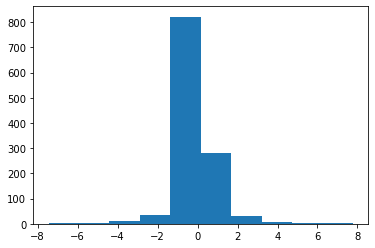

In [361]:
plt.hist(earthquake_normalized[2][0])

In [362]:
with h5py.File('earthquake_2001_to_3000_Z_20Hz_1min_norm.h5', 'w') as f:
    f.create_dataset('quake', data=earthquake_normalized)

### Visualize the waveforms with the 10 largest durations

In [372]:
cat_good_earthquake = pd.read_csv('highest_snrs_durations_peak_amp.csv')

In [377]:
cat_earthquake_dur= cat_good_earthquake.sort_values(by = 'durations_peak_amp', ascending = False)


In [379]:
len(cat_earthquake_dur)

2000

In [378]:
cat_earthquake_dur[0:10]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,...,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final,durations,durations_peak_amp
1950,1950,1950,149185,uw61602777,2020-04-22T16:15:06.470000Z,46.202,-122.187,earthquake,1.350,1.28,...,1.28,0.413,1.73,0.675,NaN,0,0,43.745,50.05,49.03
785,785,785,130396,uw61562126,2019-11-30T01:45:12.620000Z,42.776,-124.477,earthquake,16.650,4.53,...,4.53,0.125,4.87,0.162,NaN,0,0,49.695,57.21,46.89
1549,1549,1549,181578,uw61886506,2022-10-07T12:52:36.010000Z,44.540,-122.551,earthquake,13.170,4.39,...,4.39,0.171,5.24,0.224,NaN,0,0,45.192,62.38,46.26
1768,1768,1768,94898,uw61064752,2015-09-12T22:22:12.400000Z,47.518,-121.750,earthquake,18.830,3.93,...,3.93,0.146,4.29,0.422,NaN,0,0,44.400,60.37,45.82
1454,1454,1454,32861,uw10801973,2010-08-28T03:52:18.650000Z,45.358,-121.767,earthquake,4.566,1.64,...,1.64,0.076,1.60,0.040,NaN,2,0,45.559,47.34,44.53
1574,1574,1574,97335,uw60978236,2015-03-02T18:04:23.780000Z,46.848,-121.766,earthquake,0.117,1.22,...,1.22,0.180,0.99,0.629,NaN,0,0,45.072,39.70,38.96
1127,1127,1127,10827,uw10701498,2006-10-08T02:48:26.650000Z,46.850,-121.600,earthquake,1.649,4.50,...,NaN,NaN,4.50,0.040,NaN,0,0,47.099,59.44,37.15
856,856,856,175194,uw61869652,2022-09-08T08:08:25.830000Z,47.842,-122.752,earthquake,23.330,3.71,...,3.71,0.200,4.00,0.200,NaN,0,0,48.994,45.49,36.70
986,986,986,58676,uw60578187,2013-08-23T21:38:35.370000Z,46.322,-122.385,earthquake,13.749,3.68,...,3.68,0.180,3.88,0.312,NaN,0,0,48.025,41.13,36.39
1912,1912,1912,133296,uw61548131,2019-09-05T06:35:15.930000Z,45.360,-121.695,earthquake,3.860,1.42,...,1.42,0.130,1.54,0.012,NaN,0,0,43.881,40.49,36.27


In [380]:
# Convert into traces
stream_earthquake_dur = extract_waveforms(cat_earthquake_dur, comcat_file_name)
tr_earthquake_Z_dur = convert_into_traces(stream_earthquake_dur, cat_earthquake_dur).select(channel = '*HZ')

In [382]:
# Define trace
trace = tr_earthquake_Z_dur[0:10]

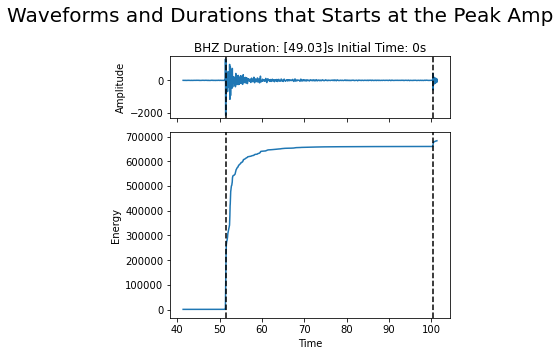

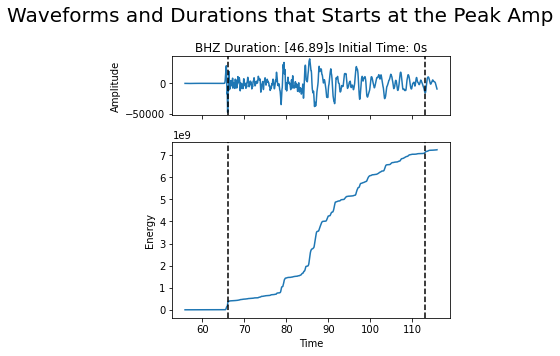

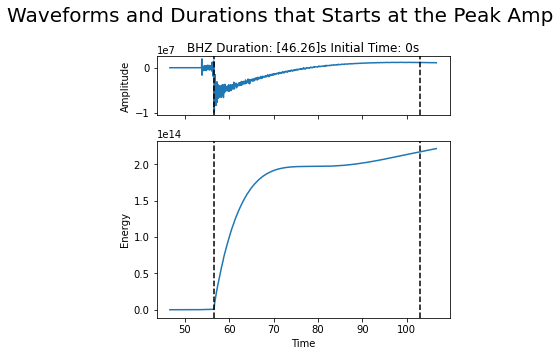

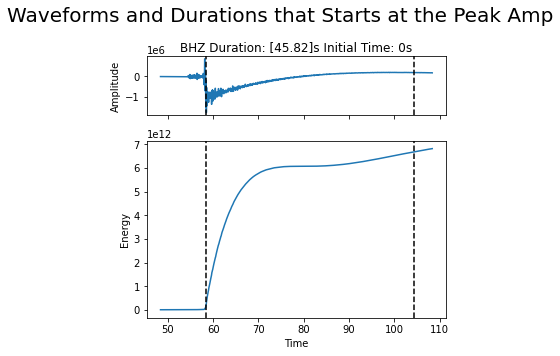

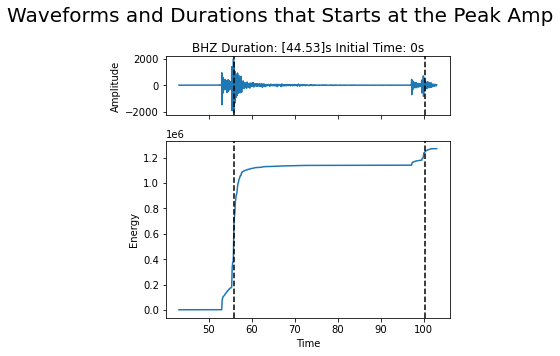

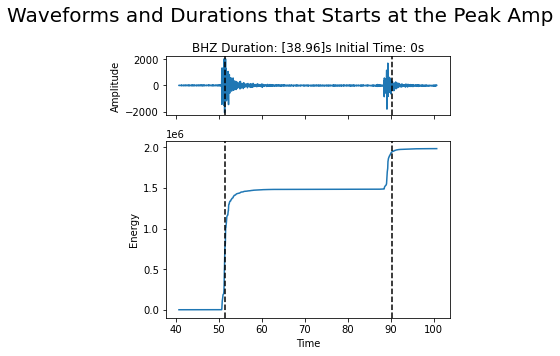

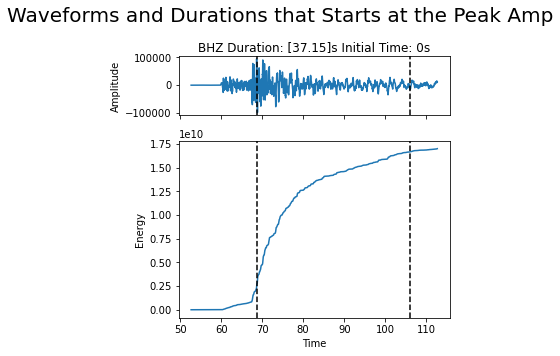

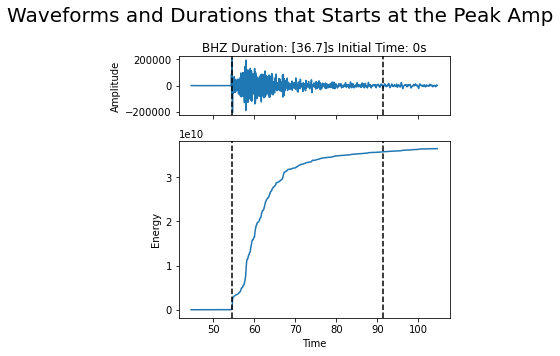

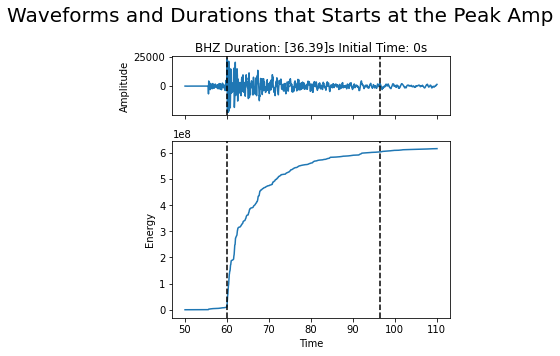

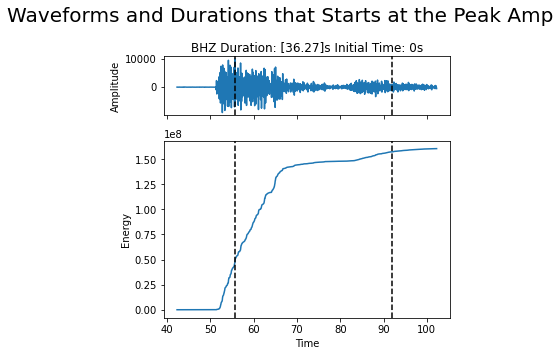

In [383]:
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=50

duration = []
array = np.zeros((2000, 1, 6000))

for i in range(len(trace)):
    fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
    lower_time_index =  lower_index - time_before_p * sampling_rate
    upper_time_index =  lower_index + time_after_p * sampling_rate
    
    new_d = d[lower_time_index:upper_time_index]
    new_t = t[lower_time_index:upper_time_index]
    new_a = a[lower_time_index:upper_time_index]
    
    trace_abs = abs(new_d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

#     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
    upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]
    
    dur = new_t[upper_index] - new_t[peak_amp_index]

    duration.append(dur[0])
    
    array[i,0,:] = new_d
    
    # plotting the seismogram
    axs[0].plot(new_t, new_d)
    axs[0].set_ylabel('Amplitude')
#     axs[0].set_xlim(xlim[0], xlim[1])
    axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
    axs[0].axvline(new_t[upper_index], ls = '--', color='black')
    axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
    axs[1].plot(new_t, new_a)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Energy')        
#     axs[1].set_xlim(xlim[0], xlim[1])
    axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
    axs[1].axvline(new_t[upper_index], ls = '--', color='black')
        
    fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()

In [299]:
d[upper_time_index:lower_time_index]

array([-158.73023135, -216.73263805, -260.23504785, ...,    0.67158416,
          0.42179211,    3.1724827 ])

In [292]:
d[lower_time_index:upper_time_index]

array([], dtype=float64)

In [295]:
upper_time_index

5710

In [298]:
d.shape[0]-290

14710

In [122]:
print(wave_noise[0][0][:])
print(max(wave_noise[0][0][:]))
print(min(wave_noise[0][0][:]))
print(n2[0][0])

[ -6.61958852 -25.71231668  12.34489828 ...  -1.51174871  -0.31098315
  -4.21055622]
46.72455278955947
-77.28778588844028
[0.56984811 0.41588982 0.72277231 ... 0.61103627 0.6207189  0.58927386]


In [ ]:
noise_normalized = wave_noise/()

(array([1.000e+00, 4.000e+00, 1.200e+01, 4.500e+01, 4.540e+02, 1.917e+03,
        5.080e+02, 4.300e+01, 1.000e+01, 6.000e+00]),
 array([-77.28778589, -64.88655202, -52.48531815, -40.08408429,
        -27.68285042, -15.28161655,  -2.88038268,   9.52085119,
         21.92208505,  34.32331892,  46.72455279]),
 <BarContainer object of 10 artists>)

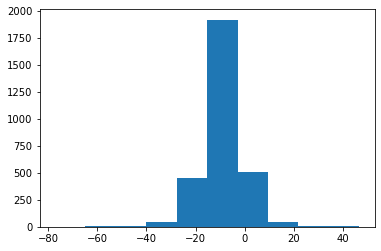

In [126]:
plt.hist(wave_noise[0][0])

(array([1.000e+00, 4.000e+00, 1.200e+01, 4.500e+01, 4.540e+02, 1.917e+03,
        5.080e+02, 4.300e+01, 1.000e+01, 6.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

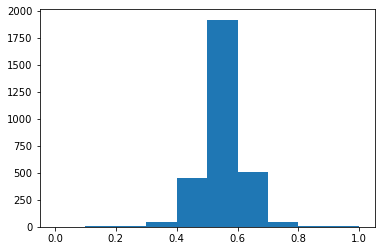

In [127]:
plt.hist(n2[0][0])

In [59]:
cat_high_snrs['trace_snr_db']

0       70.354|74.938|76.523
1       78.355|77.278|73.933
2       61.279|59.563|73.801
3       61.517|77.406|73.368
4       69.742|74.111|73.215
                ...         
1995          nan|nan|43.633
1996    49.609|48.866|43.632
1997      41.697|38.43|43.63
1998    42.407|48.111|43.629
1999          nan|nan|43.628
Name: trace_snr_db, Length: 2000, dtype: object

In [14]:
array_earthquake = extract_waveforms(cat_high_snrs, comcat_file_name)
array_earthquake = convert_into_traces(array_earthquake, cat_high_snrs).select(channel = '*HZ')

In [22]:
array_earthquake[20].data

array([ 1.24978844,  3.50006242,  3.49978768, ..., -1.75015818,
       -0.74983365,  0.24997165])

In [24]:
array_earthquake_abs = abs(array_earthquake[20].data)
print(array_earthquake_abs)

[1.24978844 3.50006242 3.49978768 ... 1.75015818 0.74983365 0.24997165]


In [26]:
peak_amp = max(array_earthquake_abs)
print(peak_amp)

40622.483053262215


In [28]:
peak_amp_index = np.where(array_earthquake_abs == peak_amp)
print(peak_amp_index)


(array([5540]),)


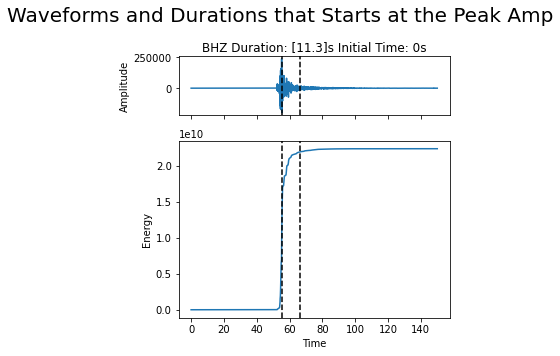

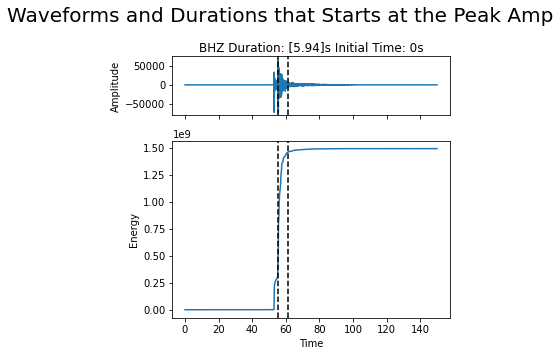

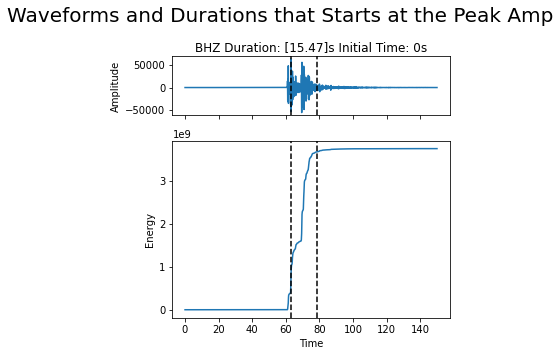

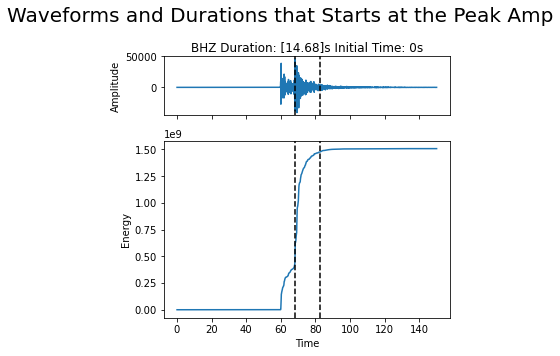

In [34]:
duration=[]
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=90

trace = array_earthquake[0:4]
for i in range(len(trace)):
    fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
    
    sampling_rate = 100
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
    
    trace_abs = abs(d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

    lower_index = peak_amp_index
    upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
    dur = t[upper_index] - t[lower_index]
    duration.append(dur)
    
    ## plotting the seismogram
    axs[0].plot(t, d)
    axs[0].set_ylabel('Amplitude')
#     axs[0].set_xlim(xlim[0], xlim[1])
    axs[0].axvline(t[lower_index], ls = '--', color='black')
    axs[0].axvline(t[upper_index], ls = '--', color='black')
    axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
    axs[1].plot(t, a)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Energy')        
#     axs[1].set_xlim(xlim[0], xlim[1])
    axs[1].axvline(t[lower_index], ls = '--', color='black')
    axs[1].axvline(t[upper_index], ls = '--', color='black')
        
    fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()

In [45]:
duration=[]
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=90

trace = array_earthquake
for i in range(len(trace)):
    
    sampling_rate = 100
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
    
    trace_abs = abs(d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

    lower_index = peak_amp_index
    upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
    dur = t[upper_index] - t[lower_index]
    duration.append(dur[0])

In [46]:
duration[0]

11.299999999999997

In [38]:
(len(duration))

2000

In [ ]:
# Read the waveform data downsampled to 20 Hz
with h5py.File('good_earthquake_Z_20Hz.h5', 'r') as f:
    wave1 = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave1.shape)